# AutoSleep Data Analysis

Data analysis for sleep tracking from AutoSleep iOS App

NOTE: In order to use, manually export your data from the history tab. You'll need to swipe left to go back to previous periods. Upload your export files into /data/ directory and ensure each is prefaced by AutoSleep

In [1]:
from datetime import date, datetime as dt, timedelta as td
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

In [2]:
# supress warnings
import warnings
warnings.filterwarnings('ignore')

----

#### Import Data

In [3]:
import glob
import os

In [4]:
# import multiple autosleep data exports and create a single data frame
path = 'data/'
allFiles = glob.glob(path + "/AutoSleep*csv")
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0)
    list_.append(df)
sleep = pd.concat(list_)

sleep = sleep.reset_index(drop=True)

# drop any duplicates if overlap in files
sleep = sleep.drop_duplicates()

----

### Data Processing

In [5]:
# Convert to datetime
sleep['In bed at'] = pd.to_datetime(sleep['In bed at'])
sleep['Until'] = pd.to_datetime(sleep['Until'])

# sleep date: set to date of wakeup
sleep['wakeup_date'] = sleep['Until'].apply(lambda x: x.strftime('%Y-%m-%d')) 
sleep['wakeup_date'] = pd.to_datetime(sleep['wakeup_date'])
# set date to day before wakeup
sleep['date'] = sleep['wakeup_date'] -  pd.to_timedelta(1, unit='d')
sleep['year'] = sleep['date'].dt.year
sleep['month'] = sleep['date'].dt.month
sleep['mnth_yr'] = sleep['date'].apply(lambda x: x.strftime('%Y-%m'))
sleep['day'] = sleep['date'].dt.day
sleep['dow'] = sleep['date'].dt.weekday

# in_bed_hour: when was in bed
sleep['in_bed_hour'] = sleep['In bed at'].dt.hour
sleep['awake_hour'] = sleep['Until'].dt.hour 

# duration to minutes
sleep['InBed_Minutes'] = sleep['Duration'].str.split(':').apply(lambda x: int(x[0]) * 60 + int(x[1]))
sleep['Sleep_Minutes'] = sleep['Asleep'].str.split(':').apply(lambda x: int(x[0]) * 60 + int(x[1]))
sleep['Awake_Minutes'] = sleep['Time awake in bed'].str.split(':').apply(lambda x: int(x[0]) * 60 + int(x[1]))
sleep['Quality_Sleep_Minutes'] = sleep['Quality sleep'].str.split(':').apply(lambda x: int(x[0]) * 60 + int(x[1]))
sleep['Deep sleep'] = sleep['Deep sleep'].str.replace('--', '0:00', regex=True) 
sleep['Deep_Sleep_Minutes'] = sleep['Deep sleep'].str.split(':').apply(lambda x: int(x[0]) * 60 + int(x[1]))

sleep['Hours'] = round((sleep.Sleep_Minutes / 60), 2)

# sort
sleep = sleep.sort_values(by='In bed at', ascending=True)

In [6]:
# Sanity Check
# Generatee Range of Dates from First Recorded added to Last
first_sleep_date = sleep.head(1).date.values[0]
last_sleep_date = sleep.tail(1).date.values[0]
all_dates = pd.date_range(start=first_sleep_date, end=last_sleep_date)
all_dates = pd.DataFrame(all_dates, columns=['date'])

# combine actual counts with total dates possible
sleep = pd.merge(left=all_dates, right=sleep, left_on="date", right_on="date", how="inner")

# fill missing values with zero for now, perhaps better set it to median or something else?
sleep.fillna(0, inplace=True)

In [7]:
# export
sleep.to_csv("data/sleep.csv")

-----

# General Sleep Data Analysis

In [8]:
# Life-time Sleep Time Summary
print('====== Lifetime Sleep Summary from Autosleep ====== ')

first_sleep_date = pd.to_datetime(str(sleep.head(1).date.values[0])).strftime('%Y.%m.%d') 
latest_sleep_date = pd.to_datetime(str(sleep.tail(1).date.values[0])).strftime('%Y.%m.%d')
print('From {} until {}'.format(first_sleep_date, latest_sleep_date))
print(' ')
print('Total Days: {:,}'.format(len(sleep)))
print('Daily Sleep Average: {:,} hours'.format(round(sleep.Hours.mean(),2)))
print(' ')
print('Days with Most Sleep:')
for index, row in sleep.sort_values(by='Hours', ascending=False).head(5).iterrows():
    print(row['Hours'], 'hours on ', row['date'].strftime('%Y.%m.%d'))
print(' ')
print('Days with Least Sleep:')
for index, row in sleep.sort_values(by='Hours', ascending=True).head(5).iterrows():
    print(row['Hours'], 'hours on ', row['date'].strftime('%Y.%m.%d'))

====== Lifetime Sleep Summary from Autosleep ====== 
From 2017.05.29 until 2019.01.04
 
Total Days: 568
Daily Sleep Average: 7.37 hours
 
Days with Most Sleep:
11.98 hours on  2017.11.04
11.55 hours on  2017.10.06
10.87 hours on  2018.10.27
10.83 hours on  2018.01.26
10.6 hours on  2017.07.15
 
Days with Least Sleep:
0.35 hours on  2017.07.19
1.23 hours on  2018.12.23
1.7 hours on  2017.10.22
2.68 hours on  2018.10.20
3.3 hours on  2018.08.24


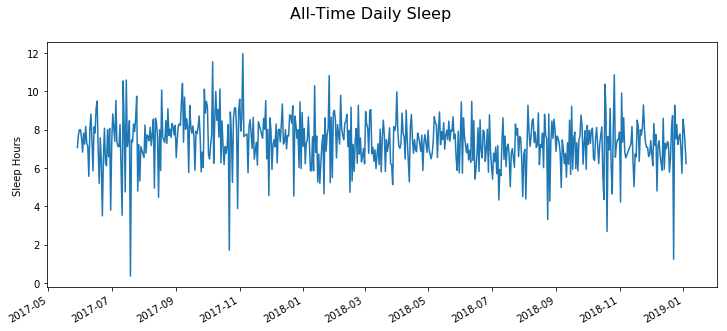

In [9]:
# Chart It!
ax = sleep.plot(x='date', y='Hours', figsize=[12, 5], legend=False)
plt.suptitle('All-Time Daily Sleep', fontsize=16)
ax.set_xlabel('')
ax.set_ylabel("Sleep Hours")

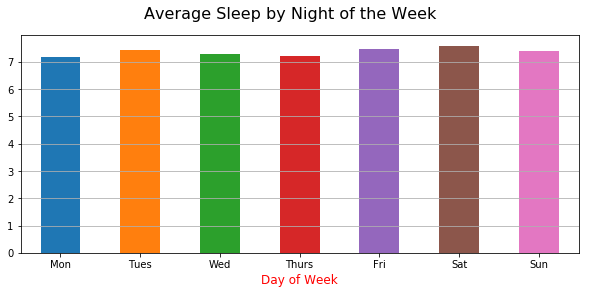

In [10]:
# Dow of Week Sleep Average
data = sleep.groupby(['dow'])['Hours'].mean()

fig, ax = plt.subplots(figsize=[10, 4])
ax = data.plot(kind='bar', x='day_of_week')

n_groups = len(data)
index = np.arange(n_groups)
opacity = 0.5

ax.yaxis.grid(True)

plt.suptitle('Average Sleep by Night of the Week', fontsize=16)
dow_labels = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
plt.xticks(index, dow_labels, rotation=0)
plt.xlabel('Day of Week', fontsize=12, color='red')

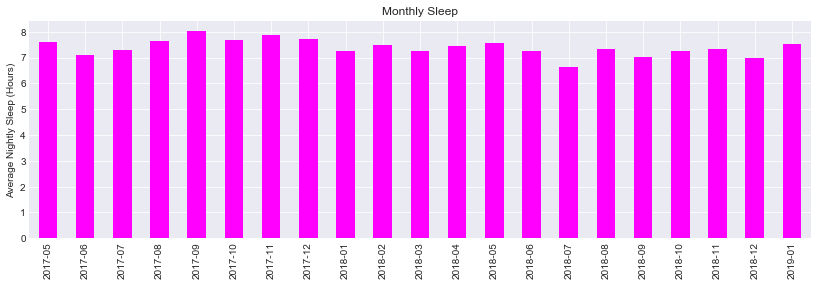

In [11]:
# Monthly Breakdown
monthly_sleep = sleep.groupby(['mnth_yr'])['Hours'].mean()

# Chart Monthly Tasks Count 
dataset = monthly_sleep
chart_title = 'Monthly Sleep'

plt.style.use('seaborn-darkgrid')
ax = dataset.plot.bar(figsize=(14, 4), rot=90, colormap='spring', stacked=True, legend=False)
ax.set_ylabel('Average Nightly Sleep (Hours)')
ax.set_xlabel('')
ax.set_title(chart_title)
plt.show()

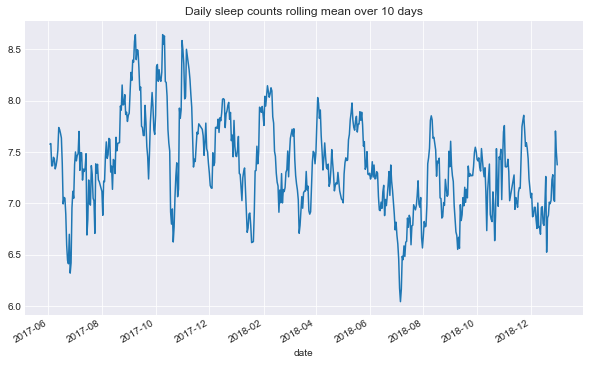

In [12]:
# Rolling Average
sleep['RollingMeanSleep'] = sleep.Hours.rolling(window=10, center=True).mean()
sleep.plot(x='date', y='RollingMeanSleep', title= 'Daily sleep counts rolling mean over 10 days', legend=False, figsize=[10, 6])

-----

# Sleep Year in Review

In [13]:
# Set Year
target_year = 2018

### Year: Top Projects

### Year: Day of Week Comparison

In [14]:
def yearly_dow_chart(year): 
    year_data = sleep[sleep['year'] == year]
    # Dow of Week Sleep Average
    data = year_data.groupby(['dow'])['Hours'].mean()

    fig, ax = plt.subplots(figsize=[10, 4])
    ax = data.plot(kind='bar', x='day_of_week')

    n_groups = len(data)
    index = np.arange(n_groups)
    opacity = 0.5

    ax.yaxis.grid(True)

    plt.suptitle('Average Sleep by Night of the Week', fontsize=16)
    dow_labels = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
    plt.xticks(index, dow_labels, rotation=0)
    plt.xlabel('Day of Week', fontsize=12, color='red')

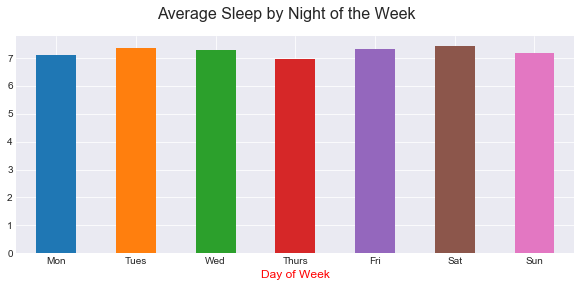

In [15]:
yearly_dow_chart(year=target_year)

### Year: Monthly Sleep Comparison Chart

In [16]:
sleep.columns

Index(['date', 'In bed at', 'Until', 'Duration', 'Asleep', 'Time awake in bed',
       'Fell asleep in', 'Quality sleep', 'Deep sleep', 'Heartrate', 'Tags',
       'Notes', 'wakeup_date', 'year', 'month', 'mnth_yr', 'day', 'dow',
       'in_bed_hour', 'awake_hour', 'InBed_Minutes', 'Sleep_Minutes',
       'Awake_Minutes', 'Quality_Sleep_Minutes', 'Deep_Sleep_Minutes', 'Hours',
       'RollingMeanSleep'],
      dtype='object')

In [17]:
def yearly_months_chart(year):   
    year_data = sleep[sleep['year'] == year]
    #yearly_months = year_data['month'].value_counts().sort_index()
    yearly_months = year_data.groupby(['mnth_yr'])['Hours'].mean()
    months_of_year = ['Jan', 'Feb', 'March', 'April', 'May', 'June', 'July', 
                      'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
    yearly_months.index = months_of_year
    
    round(yearly_months.mean(),2)
    
    # Chart Monthly Tasks Count 
    dataset = yearly_months
    chart_title = '{} Monthly Sleep | Monthly Average: {:} hrs'.format(year, round(yearly_months.mean(),2))

    plt.style.use('seaborn-darkgrid')
    ax = dataset.plot.bar(figsize=(14, 5), rot=0, colormap='spring', stacked=True, legend=False)
    ax.set_ylabel('Average Sleep')
    ax.set_xlabel('')
    ax.set_title(chart_title)
    plt.show()

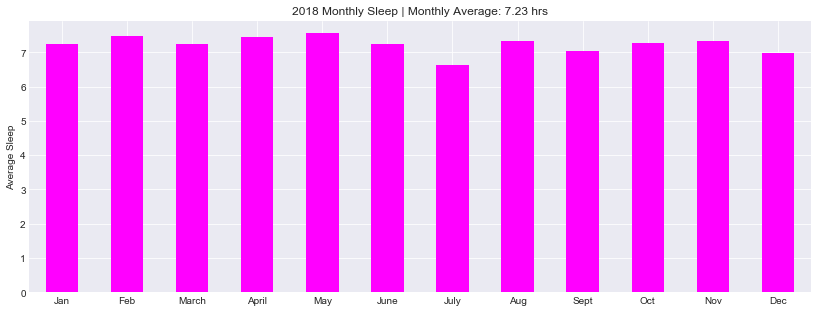

In [18]:
yearly_months_chart(year=target_year)

#### Year: Tasks Heat Map

In [19]:
# Helper Function to Create Heat Map from Data
# Adapted from https://stackoverflow.com/questions/32485907/matplotlib-and-numpy-create-a-calendar-heatmap
DAYS = ['Sun.', 'Mon.', 'Tues.', 'Wed.', 'Thurs.', 'Fri.', 'Sat.']
MONTHS = ['Jan.', 'Feb.', 'Mar.', 'Apr.', 'May', 'June', 'July', 'Aug.', 'Sept.', 'Oct.', 'Nov.', 'Dec.']


def date_heatmap(series, start=None, end=None, mean=False, ax=None, **kwargs):
    '''Plot a calendar heatmap given a datetime series.

    Arguments:
        series (pd.Series):
            A series of numeric values with a datetime index. Values occurring
            on the same day are combined by sum.
        start (Any):
            The first day to be considered in the plot. The value can be
            anything accepted by :func:`pandas.to_datetime`. The default is the
            earliest date in the data.
        end (Any):
            The last day to be considered in the plot. The value can be
            anything accepted by :func:`pandas.to_datetime`. The default is the
            latest date in the data.
        mean (bool):
            Combine values occurring on the same day by mean instead of sum.
        ax (matplotlib.Axes or None):
            The axes on which to draw the heatmap. The default is the current
            axes in the :module:`~matplotlib.pyplot` API.
        **kwargs:
            Forwarded to :meth:`~matplotlib.Axes.pcolormesh` for drawing the
            heatmap.

    Returns:
        matplotlib.collections.Axes:
            The axes on which the heatmap was drawn. This is set as the current
            axes in the `~matplotlib.pyplot` API.
    '''
    # Combine values occurring on the same day.
    dates = series.index.floor('D')
    group = series.groupby(dates)
    series = group.mean() if mean else group.sum()

    # Parse start/end, defaulting to the min/max of the index.
    start = pd.to_datetime(start or series.index.min())
    end = pd.to_datetime(end or series.index.max())

    # We use [start, end) as a half-open interval below.
    end += np.timedelta64(1, 'D')

    # Get the previous/following Sunday to start/end.
    # Pandas and numpy day-of-week conventions are Monday=0 and Sunday=6.
    start_sun = start - np.timedelta64((start.dayofweek + 1) % 7, 'D')
    end_sun = end + np.timedelta64(7 - end.dayofweek - 1, 'D')

    # Create the heatmap and track ticks.
    num_weeks = (end_sun - start_sun).days // 7
    heatmap = np.zeros((7, num_weeks))
    ticks = {}  # week number -> month name
    for week in range(num_weeks):
        for day in range(7):
            date = start_sun + np.timedelta64(7 * week + day, 'D')
            if date.day == 1:
                ticks[week] = MONTHS[date.month - 1]
            if date.dayofyear == 1:
                ticks[week] += f'\n{date.year}'
            if start <= date < end:
                heatmap[day, week] = series.get(date, 0)

    # Get the coordinates, offset by 0.5 to align the ticks.
    y = np.arange(8) - 0.5
    x = np.arange(num_weeks + 1) - 0.5

    # Plot the heatmap. Prefer pcolormesh over imshow so that the figure can be
    # vectorized when saved to a compatible format. We must invert the axis for
    # pcolormesh, but not for imshow, so that it reads top-bottom, left-right.
    ax = ax or plt.gca()
    mesh = ax.pcolormesh(x, y, heatmap, **kwargs)
    ax.invert_yaxis()

    # Set the ticks.
    ax.set_xticks(list(ticks.keys()))
    ax.set_xticklabels(list(ticks.values()))
    ax.set_yticks(np.arange(7))
    ax.set_yticklabels(DAYS)

    # Set the current image and axes in the pyplot API.
    plt.sca(ax)
    plt.sci(mesh)

    return ax

In [20]:
def year_heat_chart(year):   

    # Filter by Year
    year_data = sleep[(sleep['year'] == year)]
    
    # daily sleep
    year_dates_data = year_data.groupby(['date'])['Hours'].sum().reset_index()
    year_dates_data.columns = ['date', 'Hours']
    year_dates_data['date'] = pd.to_datetime(year_dates_data['date'])

    # Generate all dates in that year
    first_date = str(year)+'-01-01'
    last_date = str(year)+'-12-31'
    all_dates = pd.date_range(start=first_date, end=last_date)
    all_dates = pd.DataFrame(all_dates, columns=['date'])
    
    # combine actual runs by date with total dates possible
    year_data = pd.merge(left=all_dates, right=year_dates_data, 
                                 left_on="date", right_on="date", how="outer")
    year_data['Hours'].fillna(0, inplace=True)
    year_data = year_data.set_index(pd.DatetimeIndex(year_data['date']))
    
    max_daily_count = round(year_data['Hours'].max(),2)
    
    # key stat and title
    averageSleep = round(year_dates_data['Hours'].mean(),2)
    chart_title = '{} Sleep Heatmap | Nightly Average: {:,} hours'.format(year, averageSleep)
    
    # set chart data
    data = year_data['Hours']
    data.index = year_data.index 
    
    # plot data
    figsize = plt.figaspect(7 / 56)
    fig = plt.figure(figsize=figsize)
    ax = date_heatmap(data, edgecolor='black')
    max_count = int(round(data.max(),0))
    steps = int(round(max_count / 6, 0))
    plt.colorbar(ticks=range(0, max_count, steps), pad=0.02)
    cmap = mpl.cm.get_cmap('Purples', max_daily_count)
    plt.set_cmap(cmap)
    plt.clim(0, max_daily_count)
    ax.set_aspect('equal')
    ax.set_title(chart_title)
    plt.show()

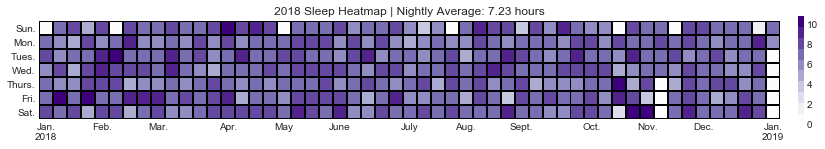

In [21]:
year_heat_chart(year=target_year)

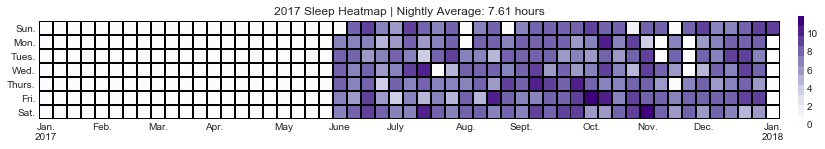

In [22]:
# compare previous year: 
year_heat_chart(year=2017)

### Year Rolling Average

In [23]:
def year_rolling_chart(year):
    # Filter by Year
    year_data = sleep[(sleep['year'] == year)]
    # Rolling Average
    year_data['RollingMeanSleep'] = year_data.Hours.rolling(window=10, center=True).mean()
    ax = year_data.plot(x='date', y='RollingMeanSleep', 
                   legend=False, figsize=[12, 4])
    chart_title = 'est'
    ax.set_title('{} Rolling Average of Nightly Sleep in Hours'.format(year))
    ax.set_ylabel('Hours')
    ax.set_xlabel('')
    plt.show()

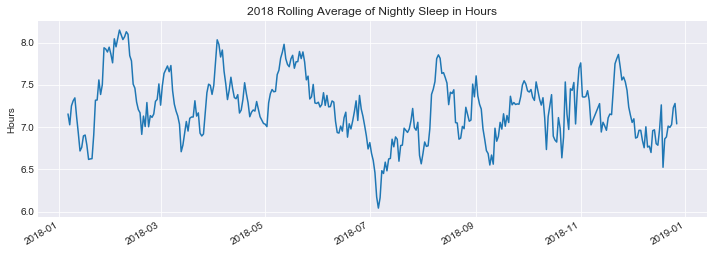

In [24]:
year_rolling_chart(year=target_year)

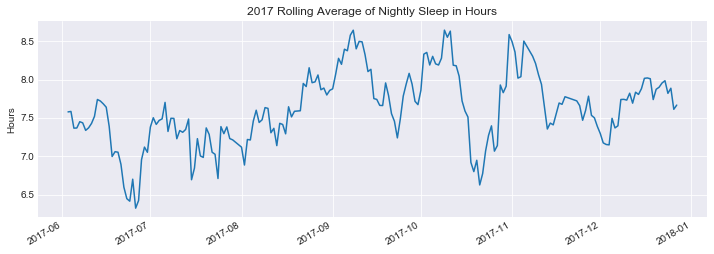

In [25]:
year_rolling_chart(year=2017)

### Yearly Summary

In [26]:
def yearly_summary(year):  
    print('====== {} AutoSleep Sleep Summary ======'.format(year))
    # Data Setup
    year_data = sleep[(sleep['year'] == year)]
    
    print('Total Days of Tracked Sleep: {:,}'.format(len(year_data)))
    
    daily_average = round(year_data.Hours.mean(),2)
    print('Daily Sleep Average: {:,} hours'.format(daily_average))
    print(' ')
    print('=== Top Sleep Nights ===')
    for index, row in year_data.sort_values(by='Hours', ascending=False).head(5).iterrows():
        print(row['Hours'], 'hours on ', row['date'].strftime('%Y.%m.%d'))
    print(' ')
    print('=== Most Sleepless Nights ===')
    for index, row in year_data.sort_values(by='Hours', ascending=True).head(5).iterrows():
        print(row['Hours'], 'hours on ', row['date'].strftime('%Y.%m.%d'))
    
    print(' ')

In [27]:
yearly_summary(year=target_year)

====== 2018 AutoSleep Sleep Summary ======
Total Days of Tracked Sleep: 357
Daily Sleep Average: 7.23 hours
 
=== Top Sleep Nights ===
10.87 hours on  2018.10.27
10.83 hours on  2018.01.26
10.38 hours on  2018.10.18
10.3 hours on  2018.01.12
9.98 hours on  2018.04.01
 
=== Most Sleepless Nights ===
1.23 hours on  2018.12.23
2.68 hours on  2018.10.20
3.3 hours on  2018.08.24
4.22 hours on  2018.11.02
4.27 hours on  2018.08.26
 
